## Bias-Variance Tradeoff and Cross-Validation

## Lab 04 for PH 290: Targeted Learning in Biomedical Big Data

### Author: [Nima Hejazi](https://nimahejazi.org)

### Date: 07 February 2018

### Attribution: adapted from source materials by [David Benkeser](https://www.benkeserstatistics.com/)

In [1]:
options(repr.plot.width = 4, repr.plot.height = 3)  ## resizing plots
options(scipen = 999)  ## has scientific notation ever annoyed you?
library(tidyverse)
library(data.table)
library(origami)
library(ggsci)
set.seed(76548208)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.2.0.9000
✔ readr   1.1.1          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

origami: Generalized Cross-Validation Framework
Version: 1.0.0


## I. Introduction
In class we have been working through the roadmap to targeted learning. This started with defining a statistical model,
defined as the set of all possible data generating distributions. The statistical target parameter was defined as a function
of a probability distribution, or in other words, a summary measure of the population of interest. We then saw how the interpretation
of some statistical target parameters could be enriched by making untestable assumptions via a structural causal model. Conversely,
we could start with the structural causal model and determine what interventions are of scientific interest. A causal parameter can
be defined on the post-intervention distribution that is equal (under assumptions) to some statistical target parameter. If the
assumptions do not hold, then the causal interpretation is not justified, but nevertheless the statistical target parameter may
be an interesting object to study. 

What we have often seen in class is that many statistical target parameters that are motivated causal parameters involve some 
possibly high dimensional object. For example, in the setting where $O = (W, A, Y)$ and our interest is in estimating the counterfactual parameter $E_0(Y_1)$, we found that the statistical target parameter $E_0(E_0(Y \ \mid \ A = 1, W))$ was equal to 
the counterfactual parameter under the assumption of randomization and positivity. Thus far in lab, we have been computing these statistical target parameters using an (effectively) infinite sample. However, in practice we rarely get to see a truly infinite sample size, which is why we have to consider the problem of statistical estimation. That is, how can be get the best estimate of the target parameter $E_0(E_0(Y \ \mid \ A = 1, W))$ when we don't get to observe the whole population.

## II. Example with a Simple SCM
Let's consider the following SCM:
\begin{align*}
U_W &\sim \mbox{Discrete Uniform}(0,50)\\
U_A &\sim \mbox{Normal}(0,1) \\
U_Y &\sim \mbox{Normal}(0,3^2) \ ,
\end{align*}
and structural equations \begin{align*}
f_{W}(U_{W}) &= U_{W} \\
f_A(W, U_A) &= I(\mbox{expit}(0.02 W + U_A) > 0.5)\\
f_Y(W, A, U_Y) &= -W + 10 A - U_Y \ . 
\end{align*}

As with the last lab, we can explicity code this distribution in `R`. First, we write functions to represent each structural equation.

In [2]:
# structural equation for W
f_W <- function(U_W) {
    return(U_W)
}

# structural equation for A
f_A <- function(W, U_A) {
    return(as.numeric(plogis(0.02 * W + U_A) > 0.25))
}

# structural equation for Y
f_Y <- function(W, A, U_Y) {
    return(-W + 10 * A - U_Y)
}

Now define a function to generate an observation from this SCM.

In [3]:
# function to draw n observations from an scm
# n = the number of observations to draw
# returns a tibble with named columns
simObsSCM <- function(n) {
    ## first we draw the errors
    # draw Uniform(-0.5, 50.5) and round
    U_W <- round(runif(n, -0.5, 50.5))
    # draw U_A
    U_A <- rnorm(n, 0, 1)
    # draw U_Y
    U_Y <- rnorm(n, 0, 3)

	#evaluate the observations sequentially
    # evaluate W
    W <- f_W(U_W)
    # evaluate A
    A <- f_A(W = W, U_A = U_A)
    # evaluate Y
    Y <- f_Y(W = W, A = A, U_Y = U_Y)

    ## return a data.frame object
    out <- as.data.table(cbind(W = W, A = A, Y = Y))
    return(out)
}

Similar to the last lab, we can write a function that intervenes on the SCM in order to calculate the true value of the counterfactual parameter, which we will need to benchmark our estimates.

In [4]:
# function that draws n observations from an SCM that is 
# intervened on to set A = setA
# n = number of observations
# setA = the value to set A equal to (0 or 1)
# returns a data.frame of coutnerfactual observations
simIntSCM <- function(n, set_A = 1) {
	## first we draw the errors
    # draw Uniform(-0.5,50.5) and round
    U_W <- round(runif(n, -0.5, 50.5))
    # draw U_A
    U_A <- rnorm(n, 0, 1)
    # draw U_Y
    U_Y <- rnorm(n, 0, 1)

	# evaluate the observations sequentially
    # evaluate W
    W <- f_W(U_W)
    # evaluate A
    A <- rep(set_A, n)
    # evaluate Y
    Y <- f_Y(W = W, A = A, U_Y = U_Y)

    ## return a data.frame object
    out <- as.data.table(cbind(W = W, A = A, Y = Y))
    return(out)
}

Let's compute the true value by simulating a large sample using `simIntSCM`.

In [5]:
int_big_samp <- simIntSCM(n = 1e6, set_A = 1)
E0Y1 <- mean(int_big_samp$Y)
round(E0Y1, 3)

[1] -15.002

The true value of $E_0(Y_1)$ is given above. In the last lab, we computed the true value of a causal effect when $W$ only assumed four unique values. In this example, $W$ assumes fifty one unique values. However, our identification result did not rely on $W$ being discrete or low-dimensional, so we can numerically confirm that indeed $E_0(Y_1) = E_0(E_0(Y \mid A = 1, W))$.

In [6]:
# let's go ahead and write a function that takes as input
# a data frame from the observed SCM and computes the 
# mean in each strata and returns it as a vector
getStratEst <- function(data, strata = (seq_len(51) - 1)) {
    est <- rep(NA, length(strata))
    # over each unique value of W compute the mean of Y in the A=1 grp
    for (w in strata) {
         # let's check to make sure someone is in each strata
        if (sum(data$A == 1 & data$W == w) > 0) {
            est[w + 1] <- mean(data$Y[data$A == 1 & data$W == w])
        } else {
            est[w + 1] <- NA
        }
    }
    # return the vector
    est
}

# simulate very large data set from the observed SCM
big_obs <- simObsSCM(n = 5e6)

# get the stratified estimate 
E0Y_A1Ww <- getStratEst(data = big_obs)

# we know the probability that W=w, it's 1/51
pw <- rep(1/51, 51)

# sum over all the strata to get E_0(E_0(Y | A = 1, W))
E0_E0Y_A1Ww <- sum(pw * E0Y_A1Ww)

# the statistical target parameter
E0_E0Y_A1Ww <- sum(pw * E0Y_A1Ww)
E0_E0Y_A1Ww

[1] -14.99838

Indeed, we have confirmed that because the randomization and positivity assumptions hold in this example the statistical parameter is equal to the counterfactual parameter. 

However, we have been working with an effectively infinite sample size, which may not be available in practice. This enormous sample allows us to compute stable estimates of $E_0(Y \mid A = 1, W = w)$ for every stratum $w$. Let's plot the "estimated" (using the huge sample) values and the true values, which we know because we simulated the data.

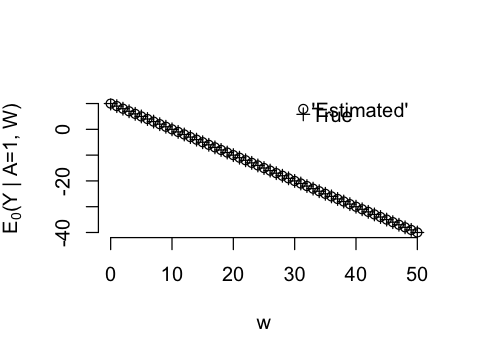

In [7]:
# vector of all w values, makes it easier to plot
allw <- (seq_len(51) - 1)

# plot "estimated" values
plot(E0Y_A1Ww ~ allw, bty="n",
     xlab="w", 
     ylab = expression(E[0]*"(Y | A=1, W)")) 

# add true values
E0Y_A1Ww_true <- -allw + 10

points(E0Y_A1Ww_true ~ allw, pch=3)
# add legend
legend(x=30, y=10, bty="n", pch = c(1,3),
       legend = c("'Estimated'", "True"))

Let's see what happens when we don't use an infinite sample size. Here's the same code run, but now only simulating $5,000$ observations.

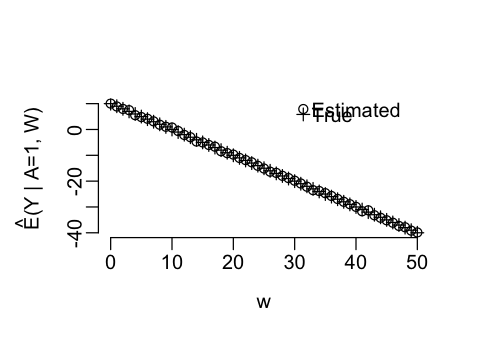

In [8]:
# simulate n=5,000 observations from the observed SCM
smallerObs <- simObsSCM(n = 5e3)

# get stratified estimates 
EhatY_A1Ww <- getStratEst(data = smallerObs)

# plot stratified-estimated values
plot(EhatY_A1Ww ~ allw, bty="n", xlab="w", 
     ylab=expression(hat(E)*"(Y | A=1, W)"),
     mgp = c(2.1,0.5,0))
# add true values
points(E0Y_A1Ww_true ~ allw, pch=3) 
# add legend
legend(x=30, y=10, bty="n", pch = c(1,3),
       legend = c("Estimated", "True"))

What about with only $500$ observations?

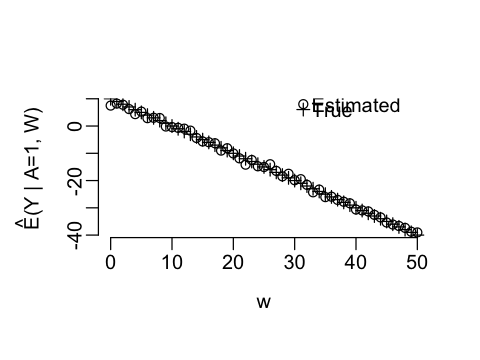

In [9]:
# simulate n=5,000 observations from the observed SCM
smallerObs <- simObsSCM(n = 5e2)

# get stratified estimates 
EhatY_A1Ww <- getStratEst(data = smallerObs)

# plot stratified-estimated values
plot(EhatY_A1Ww ~ allw, bty="n", xlab="w", 
     ylab=expression(hat(E)*"(Y | A=1, W)"),
     mgp = c(2.1,0.5,0))
# add true values
points(E0Y_A1Ww_true ~ allw, pch=3) 
# add legend
legend(x=30, y=10, bty="n", pch = c(1,3),
       legend = c("Estimated", "True"))

What about only $100$ observations?

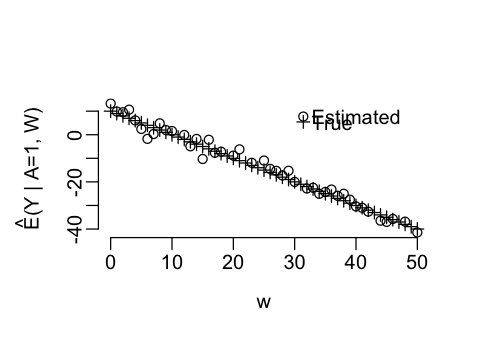

In [10]:
# simulate n=5,000 observations from the observed SCM
smallerObs <- simObsSCM(n = 1e2)

# get stratified estimates 
EhatY_A1Ww <- getStratEst(data = smallerObs)

# plot stratified-estimated values
plot(EhatY_A1Ww ~ allw, bty="n", xlab="w", 
     ylab=expression(hat(E)*"(Y | A=1, W)"),
     mgp = c(2.1,0.5,0))
# add true values
points(E0Y_A1Ww_true ~ allw, pch=3) 
# add legend
legend(x=30, y=10, bty="n", pch = c(1,3),
       legend = c("Estimated", "True"))

Now we see problems arise with the stratified estimator. 

1. When there are few observations in each strata, the estimator will have high variance. 

2. When there are no observations in a stratum, the estimator is not well defined. 

## III. Simple kernel regression
In this section we will start to explore solutions the problems with stratified estimators that we explored in the previous section. We will move into the even harder problem where $W$ is a continuous variable. With continuous variables there is no hope of constructing a stratified estimator because the probability that $W=w$ for any choice of $w$ is 0. Let's modify some of the functions from the first section to a new SCM. 

Let's consider the following SCM:
\begin{align*}
U_W &\sim \mbox{Uniform}(0,50)\\
U_A &\sim \mbox{Normal}(0,1) \\
U_Y &\sim \mbox{Normal}(0,3^2) \ ,
\end{align*}
and structural equations \begin{align*}
f_{W}(U_{W}) &= U_{W} \\
f_A(W, U_A) &= I(\mbox{expit}(0.02 W + U_A) > 0.5)\\
f_Y(W, A, U_Y) &= -W + 10 A - U_Y \ . 
\end{align*}

In [11]:
# function to draw n observations from an scm
# n = the number of observations to draw
# returns a data.frame with named columns
simObsSCM <- function(n){
    ## first we draw the errors
    # draw Uniform(-0.5,50.5) and round
    U_W <- runif(n,0,50)
    # draw U_A
    U_A <- rnorm(n,0,1)
    # draw U_Y
    U_Y <- rnorm(n,0,3)

	#evaluate the observations sequentially
    # evaluate W
    W <- f_W(U_W)
    # evaluate A
    A <- f_A(W = W, U_A = U_A)
    # evaluate Y
    Y <- f_Y(W = W, A = A, U_Y = U_Y)

    ## return a data.frame object
    out <- data.frame(W = W, A = A, Y = Y)
    return(out)
}

To solve this problem, we might begin by thinking that people in strata $w$ probably aren't that different than people in strata $w + h/2$ or people in strata $w - h/2$ for some small number $h$. For example, do we think that people with $W = 10$ differ significantly in their outcome than people with $W = 10.01$ or people with $W = 9.99$? Therefore, we might think we could obtain a good estimate by using a moving average. That is, we pick a window around each $w$ of width $h$ and then estimate the function $E_0(Y | A=1, W=w)$ with the average outcome for observations in that window.

In [12]:
# this function takes as input a dataframe of observations
# and computes the moving window average of the mean of Y
# given W at each value of the vector wValues 
# the function returns a data.frame with columns w (wValues)
simpleKern <- function(
    dat, # data.frame of observations
    h, # the size of the window
    wValues # values at which to return kernel predictions
    ){
    # for each value in wValues, compute the mean of the observed
    # data with A = 1 in that window 
    # empty vector of results
    EhatY <- rep(NA, length(wValues))
    ct <- 0
    for(w in wValues){
        ct <- ct + 1
        EhatY[ct] <- 
            mean(dat$Y[dat$A == 1 & dat$W < w + h/2 & dat$W > w - h/2])
    }
    
    return(data.frame(
        w = wValues,
        EhatY = EhatY
    ))
}

Let's try out this function for a couple choices of bandwidth. 

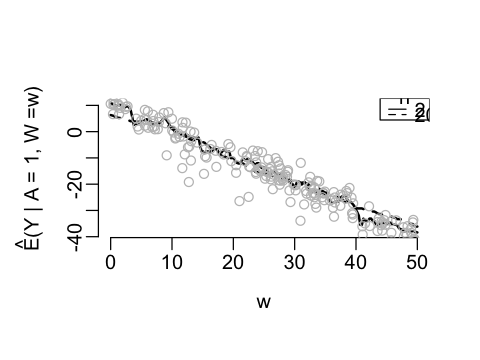

In [13]:
# try it out
dat <- simObsSCM(n=200)

# for window size 2
fit2 <- simpleKern(dat = dat, 
                  h = 2, # window of size 2
                  wValues = seq(0,50, length = 200)) # evenly spaced from 0,50
fit20 <- simpleKern(dat = dat, 
                  h = 20, # window of size 20
                  wValues = seq(0,50, length = 200)) # evenly spaced from 0,50

plot(fit2$EhatY ~ fit2$w, bty="n",xlab="w", type="l",
     ylab=expression(hat(E)*"(Y | A = 1, W =w)"),
     mgp = c(2.1, 0.5, 0),lwd=2)
lines(fit20$EhatY ~ fit20$w,lwd=2, lty=2)
points(dat$Y ~ dat$W, col="gray75")
legend(x="topright", lty=c(1,2), title="h", legend = c(2,20))

We can already see the bias/variance tradeoff in play here. The small bandwidth ($h=2$) results in a jagged fit that appears to have smaller bias, but we expect there to be more variance. The larger bandwidth ($h=20$) has bias (look at the tails), but we expect has less variance. We can confirm these by writing a function that computes a Monte Carlo estimate of the bias and variance at several points.

In [14]:
getBiasVariance <- function(
    estimator, # a function that takes as input a data set and 
               # vector of w values called 'wValues' and outputs
               # a value for the estimator at w
    truth, # a function that takes as input a vector wValues and outputs the
           # true value at those values
    n, # sample size
    wValues, # vector of strata to compute bias and variance 
    nSim = 100, # number of repeated draws to compute bias and variance
    getMSE = FALSE, # should bias and variance be returned or MSE?
    ... # other args passed to estimator (e.g., h)
){
    estMat <- NULL
    for(i in 1:nSim){
        dat <- simObsSCM(n = n)
        est <- do.call(estimator, 
                       args = c(list(dat = dat, wValues = wValues),
                                 list(...)))
        estMat <- rbind(estMat, est$EhatY)
    }
    trueValues <- do.call(truth, args = list(wValues = wValues))
    if(!getMSE){
       # compute the bias and variance
        if(is.matrix(estMat)){
            bias <- colMeans(estMat, na.rm=TRUE) - trueValues
            variance <- apply(estMat, 2, var)
        }else{
            bias <- mean(estMat, na.rm = TRUE) - trueValues
            variance <- var(estMat, na.rm = TRUE)
        }
        names(bias) <- wValues
        names(variance) <- wValues
       # return a list
        out <- list(bias = bias, variance = variance)
    }else{
        mse <- apply(matrix(1:ncol(estMat)), 1, function(i){
            mean((estMat[,i] - trueValues[i])^2)
        })
        names(mse) <- wValues
        out <- list(mse = mse)
    }
    out
}

Let's try out the function to see what it does. Here we call the function to get the Monte Carlo estimated bias and variance of $\hat{E}(Y | A=1, W=w)$ for $w \in \{5,25,45\}$, where the estimate is computed using our function `simpleKern` with $h=5$.

In [15]:
# call the function to get the estimated bias and variance of 
# \hat{E}
getBiasVariance(
    estimator = "simpleKern", # estimation function to use
    truth = function(wValues){ -wValues + 10 }, # the true value
    n = 500, # sample size
    wValues = c(5, 25, 45),
    nSim = 1000,
    h = 5
)

$bias
           5           25           45 
 0.002837806  0.026640592 -0.017318792 

$variance
        5        25        45 
0.2679447 0.2585424 0.2514270

Or alternatively, we could directly study the mean squared-error, which is a combination of bias and variance.

In [16]:
# call the function to get the estimated bias and variance of 
# \hat{E}
getBiasVariance(
    estimator = "simpleKern", # estimation function to use
    truth = function(wValues){ -wValues + 10 }, # the true value
    n = 500, # sample size
    wValues = c(5, 25, 45),
    nSim = 1000,
    h = 5, 
    getMSE = TRUE
)

$mse
        5        25        45 
0.2455079 0.2124554 0.2248778

Now let's run for a few different choices of $h$ at a single point $W=25$ to get bias and variances of our simple estimator at that points.

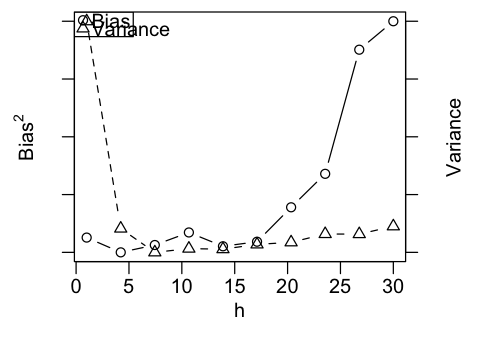

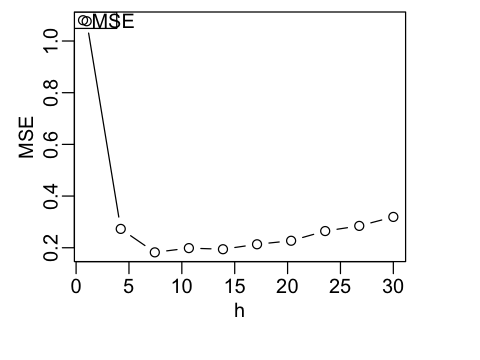

In [17]:
# I'm going to be repeating the same code under several different  
# scenarios, so let's go ahead and write a function that takes an input
# of h's and outputs a graph of the the Bias^2 and Variance at a particular 
# point for each of those choices of bandwidth. 
plotBiasVariance <- function(hGrid, wValue, n, 
                             estimator = "simpleKern",
                             plotMSE = FALSE){
    rslt <- lapply(split(hGrid, hGrid), getBiasVariance, 
                   estimator = estimator, 
                   truth = function(wValues){ f_Y(W=wValues, A=1, U_Y = 0) },
                   n = n, getMSE = plotMSE,
                   wValues = wValue, 
                   nSim = 1000)
    
    if(!plotMSE){
       # transform result list into data.frame
        biasRslt <- data.frame(h=hGrid, 
                               bias=unlist(lapply(rslt, function(x){x$bias}),
                                           use.names=FALSE))
        varRslt <- data.frame(h=hGrid, 
                              variance=unlist(
                                  lapply(rslt, function(x){x$variance}),
                                          use.names = FALSE))
        # standardize results to put on same graph
        biasRslt$bias2_s <- 
            (biasRslt$bias^2 - min(biasRslt$bias^2))/diff(range(biasRslt$bias^2))
      varRslt$variance_s <- 
            (varRslt$variance -min(varRslt$variance))/diff(range(varRslt$variance))

        # plot results
        par(mar = c(4.1, 3.1, 0.5, 3.1), mgp = c(1.5, 0.5, 0))
        plot(bias2_s ~ h, data = biasRslt, type="b",yaxt="n", 
             xlab = "h", ylab = expression(Bias^2))
        points(variance_s ~ h, data = varRslt, type="b", pch=2, lty=2)
        axis(side = 2, at = seq(0,1,length = 5), labels = rep("", 5))
        axis(side = 4, at = seq(0,1,length = 5), labels = rep("", 5))
        mtext(side = 4, line = par()$mgp[1], "Variance")
        legend(x="topleft", pch = c(1,2), legend = c("Bias", "Variance"))
    }else{
        # mse results list into data.frame
        mseRslt <- data.frame(h=hGrid, 
                              mse=unlist(lapply(rslt, function(x){x$mse}),
                                           use.names=FALSE))
        # plot results
        par(mar = c(4.1, 3.1, 0.5, 3.1), mgp = c(1.5, 0.5, 0))
        plot(mse ~ h, data = mseRslt, type="b",
             xlab = "h", ylab = expression(MSE))
        legend(x="topleft", pch = c(1,2), legend = c("MSE"))
    }
}

# run the function to plot bias and variance
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 30, length = 10), 
                 wValue = 25, 
                 n = 500)

# run the function plot MSE
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 30, length = 10), 
                 wValue = 25, 
                 n = 500, plotMSE = TRUE)

It looks from the results like using a bandwidth of $h=7$ -ish results in the optimal bias-variance trade-off (at least for estimate $E_0(Y | A = 1, W = 25)$). What happens if we change the sample size? Heuristically, we need to be using a smaller and smaller window size to ensure there's no bias. Here are the results for $n=10,000$ and using a smaller set of bandwidths.

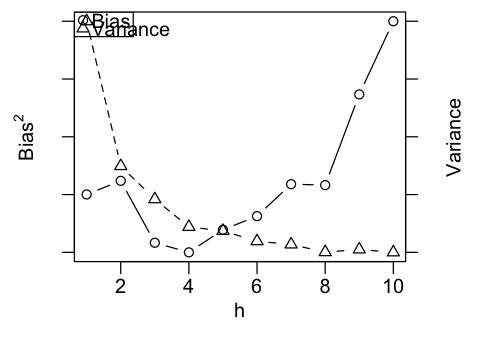

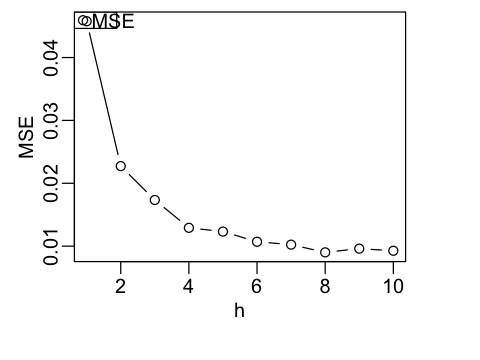

In [18]:
# plot the bias and variance
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 10, length = 10), 
                 wValue = 25, 
                 n = 10000)
# plot the mse
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 10, length = 10), 
                 wValue = 25, 
                 n = 10000, plotMSE = TRUE)

Now the optimal bandwith appears to be somewhere around $h=5$, as we'd expect. This illustrates a general point that the bandwidth should be shrinking with $n$ to maintain an optimal bias-variance trade-off. 

But just making the bandwidth get smaller with $n$ is not the whole story. What happens if we change the underlying data-generating mechanism to something that is more smooth, e.g. let's set $$
f_Y(W, A, U_Y) = -0.01 W + 10 A - U_Y \ . 
$$

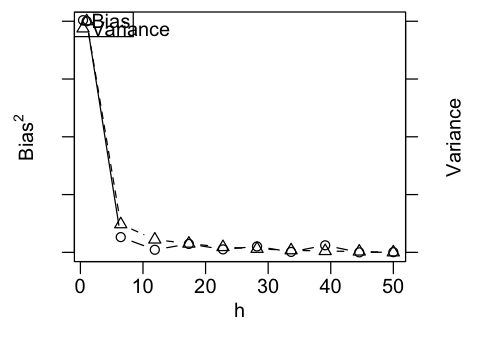

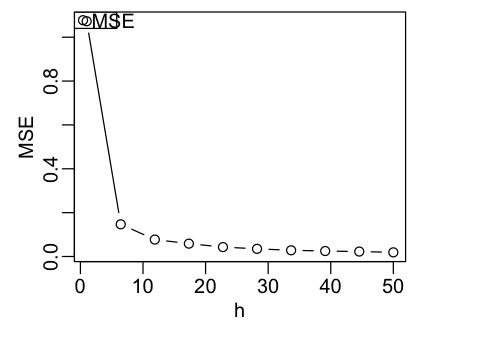

In [19]:
# redefine structural equation for Y
f_Y <- function(W, A, U_Y){
    -0.01*W + 10*A - U_Y
}
# plot the bias and variance
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 50, length = 10), 
                 wValue = 25, 
                 n = 500)

# plot the mse
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 50, length = 10), 
                 wValue = 25, 
                 n = 500, plotMSE = TRUE)

Now the optimal bandwidth is much larger. Why?

What happens if we make the data generating distribution less smooth?

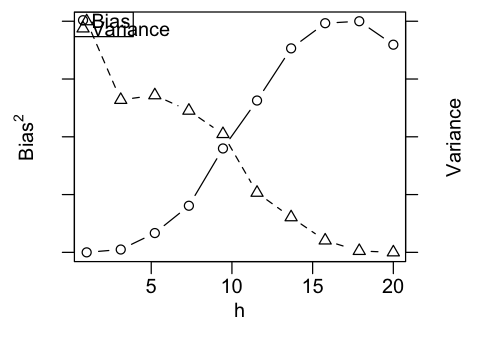

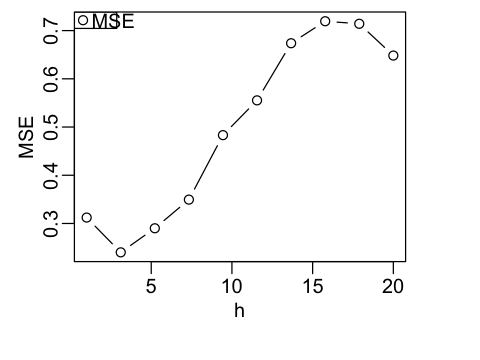

In [20]:
# redefine structural equation for Y
f_Y <- function(W, A, U_Y){
    10*sin(W/2) + 10*A - U_Y
}

# plot the bias and variance
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 20, length = 10), 
                 wValue = 25, 
                 n = 2000)

# plot the mse
set.seed(1234)
plotBiasVariance(hGrid = seq(1, 20, length = 10), 
                 wValue = 25, 
                 n = 2000, plotMSE = TRUE)

We are still cheating in these examples, because in real life we do not have access to repeated experiments to determine the optimal bandwidth. Even though we might know the rate at which the bandwidth should be decreasing (which, by the way, already requires knowing something about the underlying smoothness), we will not know for a given sample the actual bandwidth to choose. 

This motivates the use of cross-validation, which mimics repeated experiments through sample splitting. 

## IV. Other kernels

The above function `simpleKern` was an example of kernel regression using a uniform kernel. A kernel can basically be thought of as a weighting function. Above, we gave equal weight to all observations within a specified window. However, it may make more sense to weight observations nearer to the point of interest more heavily than those far away from the point of interest. Below, I write my own kernel regression function to illustrate how this works.

In [21]:
# normal kernel. Takes as input a vector of observed points wObs, 
# a bandwidth h and a single point w and returns the normal kernel 
# evaluated at each wObs.
Knorm <- function(wObs, h, w){
    dnorm((w - wObs)/h)
}

# try it out to see what it does
Knorm(wObs = 0:10, h = 5, w = 5)

# this function takes as input a dataframe of observations
# and computes the moving window average of the mean of Y
# given W at each value of the vector wValues 
# the function returns a data.frame with columns w (wValues)
kernReg <- function(
    dat, # data.frame of observations
    h, # bandwidth
    K, # kernel function that takes inputs called wObs, h, and w
    wValues # values at which to return kernel predictions
    ){
    # for each value in wValues, compute the mean of the observed
    # data with A = 1 in that window 
    # empty vector of results
    EhatY <- rep(NA, length(wValues))
    ct <- 0
    for(w in wValues){
        ct <- ct + 1
        thisK <- do.call(K, args = list(wObs = dat$W, h = h, w = w))
        EhatY[ct] <- sum(thisK * dat$Y) / sum(thisK)
    }
    
    return(data.frame(
        w = wValues,
        EhatY = EhatY
    ))
}

[1] 0.2419707 0.2896916 0.3332246 0.3682701 0.3910427 0.3989423 0.3910427
 [8] 0.3682701 0.3332246 0.2896916 0.2419707

Let's try it out.

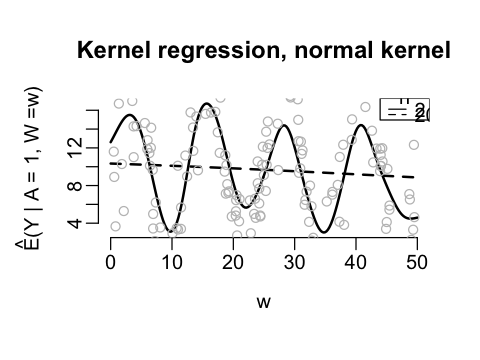

In [22]:
# try it out
dat <- simObsSCM(n=200)

# for window size 2
fit2 <- kernReg(dat = dat, K = "Knorm",
                  h = 2, # window of size 2
                  wValues = seq(0,50, length = 200)) # evenly spaced from 0,50
fit20 <- kernReg(dat = dat, K = "Knorm",
                  h = 20, # window of size 20
                  wValues = seq(0,50, length = 200)) # evenly spaced from 0,50

plot(fit2$EhatY ~ fit2$w, bty="n",xlab="w", type="l",
     ylab=expression(hat(E)*"(Y | A = 1, W =w)"),
     mgp = c(2.1, 0.5, 0),lwd=2, main= "Kernel regression, normal kernel")
lines(fit20$EhatY ~ fit20$w,lwd=2, lty=2)
points(dat$Y ~ dat$W, col="gray75")
legend(x="topright", lty=c(1,2), title="h", legend = c(2,20))

The Epanechnikov kernel is the optimal kernel in the mean-squared error sense. 

In [23]:
# normal kernel. Takes as input a vector of observed points wObs, 
# a bandwidth h and a single point w and returns the normal kernel 
# evaluated at each wObs.
Kepan <- function(wObs, h, w){
    u <- (w - wObs)/h
    k <- 3/4 * (1-u^2)*(abs(u)<=1)
}

# try it out to see what it does
Kepan(wObs = 0:10, h = 5, w = 5)

# compare to the normal kernal
k1 <- Kepan(wObs = 0:10, h = 5, w = 5)
k2 <- Knorm(wObs = 0:10, h = 5, w = 5)
comp <- cbind(
    k1/sum(k1),
    k2/sum(k2)
)
colnames(comp) <- c("Epanechnikov", "Normal")
comp

Epanechnikov,Normal
0.00000000,0.06634167
0.05454545,0.07942539
0.09696970,0.09136095
0.12727273,0.10096946
0.14545455,0.10721307
0.15151515,0.10937892
0.14545455,0.10721307
0.12727273,0.10096946
0.09696970,0.09136095
0.05454545,0.07942539


One more plot using Epanechnikov kernel.

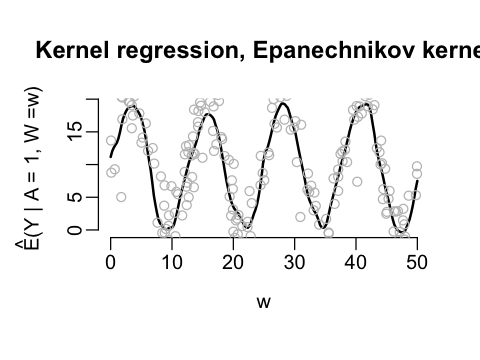

In [24]:
# try it out
dat <- simObsSCM(n=200)

# for window size 2
fit2 <- kernReg(dat = dat, K = "Kepan",
                  h = 2, # window of size 2
                  wValues = seq(0,50, length = 200)) # evenly spaced from 0,50

plot(fit2$EhatY ~ fit2$w, bty="n",xlab="w", type="l",
     ylab=expression(hat(E)*"(Y | A = 1, W =w)"),
     mgp = c(2.1, 0.5, 0),lwd=2, 
     main= "Kernel regression, Epanechnikov kernel")
points(dat$Y ~ dat$W, col="gray75")

See the `npreg` package for many more kernel regression options (and much more efficient implementation than my own!).

## V. Building R Packages: `origami`

As part of the first homework assignment, you've been asked to build a minimal R package. Today, we'll take a look at the `origami` package -- a simple and completely general package for writing arbitrary cross-validation routines.

In [25]:
data(mtcars)
head(mtcars)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


In [26]:
lm_mod <- lm(mpg ~ ., data = mtcars)
summary(lm_mod)


Call:
lm(formula = mpg ~ ., data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4506 -1.6044 -0.1196  1.2193  4.6271 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 12.30337   18.71788   0.657   0.5181
cyl         -0.11144    1.04502  -0.107   0.9161
disp         0.01334    0.01786   0.747   0.4635
hp          -0.02148    0.02177  -0.987   0.3350
drat         0.78711    1.63537   0.481   0.6353
wt          -3.71530    1.89441  -1.961   0.0633
qsec         0.82104    0.73084   1.123   0.2739
vs           0.31776    2.10451   0.151   0.8814
am           2.52023    2.05665   1.225   0.2340
gear         0.65541    1.49326   0.439   0.6652
carb        -0.19942    0.82875  -0.241   0.8122

Residual standard error: 2.65 on 21 degrees of freedom
Multiple R-squared:  0.869,	Adjusted R-squared:  0.8066 
F-statistic: 13.93 on 10 and 21 DF,  p-value: 0.0000003793


In [27]:
err <- mean(resid(lm_mod)^2)

In [28]:
cv_lm <- function(fold, data, reg_form) {
  # get name and index of outcome variable from regression formula
  out_var <- as.character(unlist(stringr::str_split(reg_form, " "))[1])
  out_var_ind <- as.numeric(which(colnames(data) == out_var))

  # split up data into training and validation sets
  train_data <- origami::training(data)
  valid_data <- origami::validation(data)

  # fit linear model on training set and predict on validation set
  mod <- lm(as.formula(reg_form), data = train_data)
  preds <- predict(mod, newdata = valid_data)

  # capture results to be returned as output
  out <- list(coef = data.frame(t(coef(mod))),
              SE = ((preds - valid_data[, out_var_ind])^2))
  return(out)
}

In [29]:
# resubstitution estimate
resub <- make_folds(mtcars, fold_fun = folds_resubstitution)[[1]]
resub_results <- cv_lm(fold = resub, data = mtcars, reg_form = "mpg ~ .")
mean(resub_results$SE)

[1] 4.609201

In [30]:
# cross-validated estimate
folds <- origami::make_folds(mtcars)
cvlm_results <- origami::cross_validate(cv_fun = cv_lm,
                                        folds = folds, data = mtcars,
                                        reg_form = "mpg ~ .")
mean(cvlm_results$SE)

[1] 13.28574

What we'll look closely at
* What goes in the R/ subdirectory of a package?
* How do we document using the Roxygen system?
* What does a vignette look like?
* What's continuous integration? `.travis.yml`?